# PROJECT 3: MADELON DATA ANALYSIS

---


In [28]:
import csv
# import psycopg2 as pg2
# from psycopg2.extras import RealDictCursor
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import shuffle

%matplotlib inline

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, ShuffleSplit, StratifiedShuffleSplit, \
                                    train_test_split, StratifiedKFold, KFold
    
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LogisticRegression, \
                                 LogisticRegressionCV, LassoCV, \
                                 ElasticNetCV, RidgeCV
        

from sklearn.feature_selection import SelectKBest, \
                                      SelectFromModel, \
                                      RFE, SelectPercentile, \
                                      f_regression
            
from sklearn.pipeline import Pipeline
from IPython.display import display
from itertools import combinations

In [29]:
# Assigning file paths to variables. 
train_data_uci_madelon = './web_madelon_data/madelon_train.data.txt'
train_label_uci_madelon = './web_madelon_data/madelon_train.labels.txt'
val_data_uci_madelon = './web_madelon_data/madelon_valid.data.txt'
val_label_uci_madelon = './web_madelon_data/madelon_valid.labels.txt'
test_data_uci_madelon = './web_madelon_data/madelon_test.data.txt'
params_uci_madelon = './web_madelon_data/madelon.param.txt'


# Creating dataframes for the train, test, and val datasets.
train_uci_df = pd.read_csv(train_data_uci_madelon, delimiter=' ', header=None).drop(500, axis=1)
test_uci_df = pd.read_csv(test_data_uci_madelon, delimiter=' ', header=None).drop(500, axis=1)
val_uci_df = pd.read_csv(val_data_uci_madelon, delimiter=' ', header=None).drop(500, axis=1)


# Creating column names for all of the uci dataframes.
feature_col_names = ['feat_{}'.format(i) for i in range(0,500)]
train_uci_df.columns = feature_col_names
test_uci_df.columns = feature_col_names
val_uci_df.columns = feature_col_names


y_train = pd.read_csv(train_label_uci_madelon, header=None)
y_val = pd.read_csv(val_label_uci_madelon, header=None)

y_train.columns = ['target']
y_val.columns = ['target']


# Final DataFrames with labels
train_uci_df = pd.merge(train_uci_df, y_train, left_index=True, right_index=True)
val_uci_df = pd.merge(val_uci_df, y_val, left_index=True, right_index=True)

# 20 Columns (5 important, 15 redundant)
top_20_real_features = [28,48,64,105,128,153,241,281,318,336,338,378,433,442,451,453,455,472,475,493]
top_14_elasticnet_real_features = [64,105,153,241,318,336,338,378,442,453,455,472,475,493]
top_12_real_features = [48,64,105,128,241,318,336,338,378,442,453,475]
top_7_real_features = [64, 128, 241, 336, 338, 378, 475]
top_5_real_features = [64, 336, 338, 378, 475]
top_14_elasticnet_real_features = [64,105,153,241,318,336,338,378,442,453,455,472,475,493]
best_score_list = [28, 48, 105, 128, 153, 281, 318, 336, 338, 378, 442, 451, 455, 472, 475]

all_feat_lists = [top_20_real_features, top_12_real_features, top_7_real_features, top_5_real_features]

In [99]:
class madelon_analyzer:
    '''This class is intended to make analyzing the Madelon data easier. Instantiation
    requires a training dataframe and a validation dataframe.'''
    
    train_df = pd.DataFrame()
    val_df = pd.DataFrame()
    
    features = []
    results = {}
    params = {}
    model = ()
    best_params_ = {}
    
#     y_train = pd.Series()
#     X_train = pd.DataFrame()
#     y_val = pd.Series()
#     X_val = pd.DataFrame()

    def __init__(self, train_df, val_df):
        self.train_df = train_df
        self.val_df = val_df
        
#         self.y_train = train_df['target']
#         self.X_train = train_df[self.features]
#         self.y_val = val_df['target']
#         self.X_val = val_df[self.features]
    
    def train_val_scorer_df_maker(self, features, name, model=KNeighborsClassifier, params={}):
        '''Method parameters should include a list of features to be scored, a descriptive name for the column
        in the pandas DataFrame that is returned, an estimator for the GridSearchCV, and parameters for 
        the estimator. 
        
        The function returns a DataFrame that includes the train score and validation score from the GridSearch.'''
        
        self.results = {}
        self.features = features
        self.params = params
        self.model = model

        y_train = self.train_df['target']
        X_train = self.train_df[features]
        y_val = self.val_df['target']
        X_val = self.val_df[features]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        gridsearch = GridSearchCV(model(), param_grid=params, cv=5, n_jobs=-1)
        gridsearch.fit(X_train_scaled, y_train)
        
        self.best_params_ = gridsearch.best_params_

        train_score = gridsearch.score(X_train_scaled, y_train)
        val_score = gridsearch.score(X_val_scaled, y_val)

        self.results[name] = {'train_score':train_score, 'val_score':val_score}

        score_df = pd.DataFrame(self.results)
        return score_df


    def plot_top_down_feature_elimination_scores(self, features, model, params, random=False, reverse=False, noise=False):
        '''Method parameters require a list of features to be modeled and scored, as well as an estimator and 
        parameter grid for the GridSearchCV. From that list, a feature will be removed and the GridSearch refit
        with the new list. Train and validation scores are graphed, and points where the score decreased from the 
        previous iteration will be pointed out on the graph, until there is no more features remaining from the 
        input list. Each point will be labeled as the point that was removed before fitting and scoring.
        
        Options include: 
        random=  - if set to True, this method will randomize the input features list before plotting.
        reverse= - if set to True, this method will reverse the features list before running the method.
        noise=   - if set to True, the points plotted on the graph will be when the GridSearch score increases
                   after removal, instead of decreasing
        '''
        
        self.results = {}
        self.features = features
        self.params = params
        self.model = model
        
        # feature sorting.
        if random:
            shuffle(features)
            all_feats = features
            reverse_all_feats = list(reversed(all_feats))

        else:
            if reverse:
                all_feats = sorted(features, reverse=True)
                reverse_all_feats = sorted(features)
            else:
                all_feats = sorted(features)
                reverse_all_feats = sorted(features, reverse=True)

        self.results = {}

        #iteration through list of features, removing one feature after each iteration.
        for i in range(len(all_feats)):

            y_train = self.train_df['target']
            X_train = self.train_df[all_feats]
            y_val = self.val_df['target']
            X_val = self.val_df[all_feats]

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)

            # GridSearch fit and scoring with current iteration of feature list
            gridsearch = GridSearchCV(model(), param_grid=params, cv=5, n_jobs=-1)
            gridsearch.fit(X_train_scaled, y_train)
                        
            train_score = gridsearch.score(X_train_scaled, y_train)
            val_score = gridsearch.score(X_val_scaled, y_val)

            self.results[i] = {'train_score':train_score, 'val_score':val_score}
            
            # removing a feature from the input features list for the next iteration.
            all_feats = all_feats[:-1]

        results_df = pd.DataFrame(self.results).T

        
        # Plotting scores
        plt.figure(figsize=(10,10))
        plt.plot(results_df)
        plt.xlabel('Number of features removed from list')
        plt.ylabel('model score')
        _ = plt.xticks(range(len(features)))

        # customizing the title based on method parameters.
        if random:
            if noise:
                _ = plt.title('{}\nmodel scores from top-down feature removal (random, noise)'.format(model))
            else:
                _ = plt.title('{}\nmodel scores from top-down feature removal (random)'.format(model))
        else:
            if reverse:
                if noise:
                    _ = plt.title('{}\nmodel scores from top-down feature removal (reverse, noise)'.format(model))
                else: 
                    _ = plt.title('{}\nmodel scores from top-down feature removal (reverse, real_feats)'.format(model))
            else:
                if noise:
                    _ = plt.title('{}\nmodel scores from top-down feature removal (noise)'.format(model))
                else:
                    _ = plt.title('{}\nmodel scores from top-down feature removal (real_feats)'.format(model))

        select_feats = []
        
        # Plotting either noise or real features on the graph.
        for ind,x in enumerate(results_df['val_score']):

            if noise:
                if ind != 0 and results_df['val_score'][ind] > results_df['val_score'][ind-1]:
                    plt.plot(ind, results_df['val_score'][ind], 'o', color='b', label='feat_{}'.format(reverse_all_feats[ind-1]))
                    select_feats.append(reverse_all_feats[ind-1])
            else:
                if ind != 0 and results_df['val_score'][ind] < results_df['val_score'][ind-1]:
                    plt.plot(ind, results_df['val_score'][ind], 'o', color='r', label='feat_{}'.format(reverse_all_feats[ind-1]))
                    select_feats.append(reverse_all_feats[ind-1])

        _ = plt.legend()

        plt.show()

        return results_df, select_feats

    def list_top_dipped_feats(self, features, model, params, noise=False, random=False):
        ''' This method runs the plot_top_down_feature_elimination_scores first with reverse=False, and then again
        with reverse=True. It then returns a list with the unique features from the aggregated list of features.
        
        Method parameters require a list of features to be modeled and scored, as well as an estimator and 
        parameter grid for the GridSearchCV.
        
        Options include: 
        random=  - if set to True, this method will randomize the input features list before plotting.
        noise=   - if set to True, the points plotted on the graph will be when the GridSearch score increases
                   after removal, instead of decreasing.
        '''
        
        self.results = {}
        self.features = features
        self.params = params
        self.model = model
        
        if random:
            if noise:
                results_df_1, select_feats_1 = self.plot_top_down_feature_elination_scores(features, model, params, random=True, noise=True)
                results_df_2, select_feats_2 = self.plot_top_down_feature_elination_scores(features, model, params, random=True, noise=True)
                print("TOP RANDOMIZED NOISE FEATURES:", sorted(list(set(select_feats_1[:5]+select_feats_2[:5]))))
            else:
                results_df_1, select_feats_1 = self.plot_top_down_feature_elination_scores(features, model, params, random=True)
                results_df_2, select_feats_2 = self.plot_top_down_feature_elination_scores(features, model, params, random=True)
                print("TOP RANDOMIZED REAL FEATURES:", sorted(list(set(select_feats_1[:5]+select_feats_2[:5]))))

            return sorted(list(set(select_feats_1[:5]+select_feats_2[:5])))


        else:
            if noise:
                results_df, select_feats = self.plot_top_down_feature_elination_scores(features, model, params, noise=True)
                reverse_results_df, reverse_select_feats = self.plot_top_down_feature_elination_scores(features, model, params, reverse=True, noise=True)
                print("TOP NOISE FEATURES:", sorted(list(set(select_feats[:5]+reverse_select_feats[:5]))))

            else:
                results_df, select_feats = self.plot_top_down_feature_elination_scores(features, model, params)
                reverse_results_df, reverse_select_feats = self.plot_top_down_feature_elination_scores(features, model, params, reverse=True)
                print("TOP REAL FEATURES:", sorted(list(set(select_feats[:5]+reverse_select_feats[:5]))))

            return sorted(list(set(select_feats[:5]+reverse_select_feats[:5])))


    def rotator_score_df_generator(self, list_of_feats, model, params):
        '''This method takes a list of features, as well as a model and parameter grid for the GridSearchCV. 
        GridSearch is performed on all variations of the list with one feature removed. A pandas DataFrame
        is returned with the train and validation scores for every iteration.'''
        
        
        self.results = {}
        self.features = list_of_feats
        
        removed_feature_list = []
        rotater_list = list_of_feats

        for i in range(len(list_of_feats)):

            removed_feat = rotater_list[-1]
            feat_list = rotater_list[:-1]

            y_train = self.train_df['target']
            X_train = self.train_df[feat_list]
            y_val = self.val_df['target']
            X_val = self.val_df[feat_list]

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)

            gridsearch = GridSearchCV(model(), param_grid=params, cv=5, n_jobs=-1)
            gridsearch.fit(X_train_scaled, y_train)

            train_score = gridsearch.score(X_train_scaled, y_train)
            val_score = gridsearch.score(X_val_scaled, y_val)

            self.results[removed_feat] = {'train_score':train_score, 'val_score':val_score, }

            rotater_list = [removed_feat] + feat_list

        rotater_df = pd.DataFrame(self.results).T
        return rotater_df

    def removerizer(self, full_features_list, features_to_remove):
        '''Takes in two lists, and returns the difference between them.'''
        
        new_list = full_features_list

        for x in features_to_remove:
            new_list.remove(x)

        return new_list

    def brute_force_feature_combination_score_generator(self, list_of_feats, model, params, n_feats=2):
        '''Method parameters should include a list of features to be fit and scored by GridSearchCV, as well as 
        an estimator and parameter grid for the GridSearch. 
        
        This method finds every combination of features, with each combination of features including n_feats'''
        
        self.features = list_of_feats
        self.model = model
        self.params = params
        
        list_of_combos = []

        # Making a list of every combination of features. 
        for combo in combinations(list_of_feats, n_feats):
            list_of_combos.append(list(combo))

        # Printing the number of combinations so that I know how long the process will take.
        print('Number of combinations:', len(list_of_combos))

        self.results = {}

        # fitting and scoring all combinations of features.
        for features in list_of_combos:

            y_train = train_uci_df['target']
            X_train = train_uci_df[features]
            y_val = val_uci_df['target']
            X_val = val_uci_df[features]

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)

            gridsearch = GridSearchCV(model(), param_grid=params, cv=5, n_jobs=-1)
            gridsearch.fit(X_train_scaled, y_train)

            train_score = gridsearch.score(X_train_scaled, y_train)
            val_score = gridsearch.score(X_val_scaled, y_val)

            self.results['{}'.format(features)] = {'train_score':train_score, 'val_score':val_score, 'features':features}

        score_df = pd.DataFrame(self.results).T.sort_values('val_score', ascending=False)

        return score_df
    
    def make_set_from_list_of_lists(self, list_of_lists):
        
        uniques = []
        
        for l in list_of_lists:
            for x in l:
                uniques = uniques + [x]

        return list(set(uniques))
    
    

### These three functions are for using regression to identify colinearity in features to sort out noise features.

    def calculate_r2_for_feature(self, data, feature, model):
        new_data = data.drop(feature, axis=1)

        X_train, \
        X_test,  \
        y_train, \
        y_test = train_test_split(
            new_data,data[feature],test_size=0.25
        )

        if model == 'DecisionTreeRegressor':
            regressor = model()
            regressor.fit(X_train, y_train)
            score = regressor.score(X_test, y_test)

        else:    
            ss = StandardScaler()
            ss.fit(X_train, y_train)
            X_train_scaled = ss.transform(X_train)
            X_test_scaled = ss.transform(X_test)

            regressor = model()
            regressor.fit(X_train_scaled,y_train)

            score = regressor.score(X_test_scaled,y_test)

        return score


    def mean_r2_for_feature(self, data, feature, model):
        scores = []
        for _ in range(10):
            scores.append(self.calculate_r2_for_feature(data, feature, model))

        scores = np.array(scores)
        return scores.mean()


    def mean_r2_for_all_features(self, data, model):
        ''' 
        This method takes a pandas DataFrame and returns an r2 scores for every feature (column)
        in the DataFrame.
        '''
        feature_col_names = ['feat_{}'.format(i) for i in range(0,500)]
        
        mean_scores = []
        for col in data.drop('target', axis=1).columns:
            mean_scores.append(self.mean_r2_for_feature(data.drop('target', axis=1), col, model))
        
        mean_score_df = pd.DataFrame([mean_scores, feature_col_names]).T.sort_values(0, ascending=False)
        mean_score_df.columns = ['r2_score','feature']
        
        return mean_score_df
    
    

---

## Initial thoughts:

#### UCI Web Data

Using the unsupervised learning technique where a regressor is used to compare every feature (column) against the rest of the dataset and find correlated features, I was able to find exactly 20 features that have mean R^2 scores that are positive, and most of them are very high (in the 0.8-0.9 range) for all three of the random data subsets. Since 480/500 of the features in the madelon dataset are noise, and all three of my samples returned identical lists of features, I believe that this is a good indication that I have found my 5 predictor features and the 15 linear combinations.

---

In [58]:
# small sample lists for testing
s1_train_uci_10 = train_uci_df.sample(int(len(train_uci_df)*0.1), random_state=1)
s2_train_uci_10 = train_uci_df.sample(int(len(train_uci_df)*0.1), random_state=10)
s3_train_uci_10 = train_uci_df.sample(int(len(train_uci_df)*0.1), random_state=100)

In [71]:
MA_regression = madelon_analyzer(train_uci_df, val_uci_df)

In [56]:
s1_dtree_score_df = MA_regression.mean_r2_for_all_features(s1_train_uci_10, DecisionTreeRegressor)
s1_dtree_score_df[:25]

r2_score   feature
153  0.950689  feat_153
318   0.94568  feat_318
493  0.944942  feat_493
433  0.944133  feat_433
378   0.94194  feat_378
241  0.941574  feat_241
28   0.941266   feat_28
48   0.937087   feat_48
442  0.936834  feat_442
451  0.933365  feat_451
472  0.932587  feat_472
475  0.931988  feat_475
453   0.93014  feat_453
105  0.930066  feat_105
281  0.929985  feat_281
336  0.916205  feat_336
64   0.905349   feat_64
128  0.847379  feat_128
455  0.475707  feat_455
338  0.391734  feat_338
415 -0.701651  feat_415
481 -0.722338  feat_481
425 -0.729802  feat_425
26  -0.738111   feat_26
288 -0.746825  feat_288

In [62]:
s2_dtree_score_df = MA_regression.mean_r2_for_all_features(s2_train_uci_10, DecisionTreeRegressor)
s2_dtree_score_df[:25]

r2_score   feature
281  0.952507  feat_281
153  0.946635  feat_153
451  0.944464  feat_451
28   0.943324   feat_28
378  0.941291  feat_378
241  0.938696  feat_241
48   0.937395   feat_48
475  0.934721  feat_475
433  0.934397  feat_433
336  0.932545  feat_336
453  0.931917  feat_453
318   0.92465  feat_318
128   0.92428  feat_128
105  0.916439  feat_105
64   0.906317   feat_64
493  0.905983  feat_493
442   0.89446  feat_442
472  0.866464  feat_472
338   0.48923  feat_338
455   0.30665  feat_455
177 -0.683134  feat_177
236 -0.787597  feat_236
312 -0.796686  feat_312
305 -0.808826  feat_305
113 -0.835156  feat_113

In [63]:
s3_dtree_score_df = MA_regression.mean_r2_for_all_features(s3_train_uci_10, DecisionTreeRegressor)
s3_dtree_score_df[:25]

r2_score   feature
281   0.94294  feat_281
48   0.941206   feat_48
28    0.93912   feat_28
128  0.938932  feat_128
378   0.93359  feat_378
241  0.930195  feat_241
318  0.928935  feat_318
336  0.928435  feat_336
105  0.926269  feat_105
433  0.926133  feat_433
493  0.922801  feat_493
453  0.922084  feat_453
475  0.920326  feat_475
451  0.918055  feat_451
442   0.91606  feat_442
64   0.911463   feat_64
472  0.903811  feat_472
153  0.895935  feat_153
455  0.508589  feat_455
338   0.49044  feat_338
424 -0.700831  feat_424
112 -0.721068  feat_112
37  -0.778771   feat_37
470 -0.790997  feat_470
11  -0.793588   feat_11

In [64]:
# Added all of my top 20 columns for the 3 random 10% samples to see if there was variation, and they all got the 
    # exact same features. This is a good sign!

s1_correlated_cols = list(s1_dtree_score_df.head(20).index)  
s2_correlated_cols = list(s2_dtree_score_df.head(20).index)    
s3_correlated_cols = list(s3_dtree_score_df.head(20).index)    

len(set(s1_correlated_cols+s2_correlated_cols+s3_correlated_cols))

20

In [67]:
s_all_results_df = pd.DataFrame([sorted(s1_correlated_cols), sorted(s2_correlated_cols), sorted(s3_correlated_cols)]).T
s_all_results_df.columns = ['sample_1', 'sample_2', 'sample_3']
s_all_results_df

sample_1  sample_2  sample_3
0         28        28        28
1         48        48        48
2         64        64        64
3        105       105       105
4        128       128       128
5        153       153       153
6        241       241       241
7        281       281       281
8        318       318       318
9        336       336       336
10       338       338       338
11       378       378       378
12       433       433       433
13       442       442       442
14       451       451       451
15       453       453       453
16       455       455       455
17       472       472       472
18       475       475       475
19       493       493       493

---

## Benchmark

I used a naive, cross validated KNeighborsClassifer as my benchmark score using the 20 features I identified above. This resulted in a validation score of 0.91333.

---

In [72]:
MA_benchmark = madelon_analyzer(train_uci_df, val_uci_df)

In [78]:
top_20_score_benchmark = MA_benchmark.train_val_scorer_df_maker(top_20_real_features, 'top_20_features').T
top_20_score_benchmark

train_score  val_score
top_20_features       0.9365   0.913333

---

## Features Selection

Using SelectKBest with k=5 on my 3 random data subsets, I was able to identify 8 unique features. Using SelectFromModel with the Lasso estimator, I was able to identify 9. Between these two lists of features, only 5 are the same. SelectFromModel returned 5 for the first dataset, 3 for the second, and 4 for the third. Moving forward, I will use GridSearchCV to tune my model hyperparameters and try various combinations of the important features I identified.

***EDIT***: I when and tested these selected features and none scored better than benchmark. I will need to re-evaluate my selection.

---

In [103]:
# All of this information is in the 0_EDA notebook. Since it was bad information, I left it out to revisit later.
# You can find lists of the features that were identified below.

## Using my madelon_analyzer to experiment with the data

In [51]:
ma_20 = madelon_analyzer(train_uci_df, val_uci_df)

In [52]:
knc_params = {
        'n_neighbors':range(1,50,2)
        }

ma_20_df = ma_20.train_val_scorer_df_maker(top_20_real_features, 'top_20_class_test',\
                                                KNeighborsClassifier, knc_params)

In [53]:
ma_20.results

{'top_20_class_test': {'train_score': 0.94750000000000001,
  'val_score': 0.91333333333333333}}

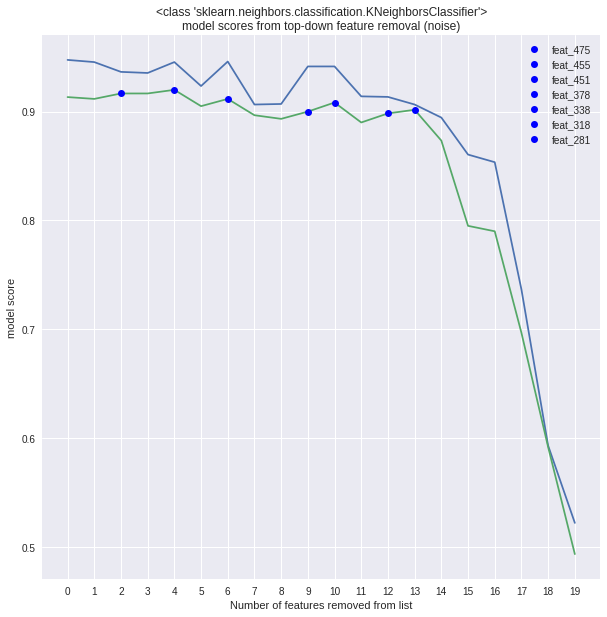

(    train_score  val_score
 0        0.9475   0.913333
 1        0.9455   0.911667
 2        0.9365   0.916667
 3        0.9355   0.916667
 4        0.9455   0.920000
 5        0.9235   0.905000
 6        0.9460   0.911667
 7        0.9065   0.896667
 8        0.9070   0.893333
 9        0.9415   0.900000
 10       0.9415   0.908333
 11       0.9140   0.890000
 12       0.9135   0.898333
 13       0.9065   0.901667
 14       0.8945   0.873333
 15       0.8605   0.795000
 16       0.8535   0.790000
 17       0.7365   0.696667
 18       0.5930   0.591667
 19       0.5220   0.493333, [475, 455, 451, 378, 338, 318, 281])

In [54]:
ma_20.plot_top_down_feature_elimination_scores(top_20_real_features, \
                                            KNeighborsClassifier, \
                                            knc_params, noise=True)

In [55]:
ma_20.params

{'n_neighbors': range(1, 50, 2)}

In [56]:
pd.DataFrame(ma_20.results).T

train_score  val_score
0        0.9475   0.913333
1        0.9455   0.911667
2        0.9365   0.916667
3        0.9355   0.916667
4        0.9455   0.920000
5        0.9235   0.905000
6        0.9460   0.911667
7        0.9065   0.896667
8        0.9070   0.893333
9        0.9415   0.900000
10       0.9415   0.908333
11       0.9140   0.890000
12       0.9135   0.898333
13       0.9065   0.901667
14       0.8945   0.873333
15       0.8605   0.795000
16       0.8535   0.790000
17       0.7365   0.696667
18       0.5930   0.591667
19       0.5220   0.493333

In [6]:
ma_best = madelon_analyzer(train_uci_df, val_uci_df)

In [66]:
rf_params = {
    'n_estimators':[10,50,100,200],
    'max_features':['auto','log2'],
}

ma_best.train_val_scorer_df_maker(best_score_list, 'best_score_MA', \
                                  model=RandomForestClassifier, params=rf_params)

best_score_MA
train_score       1.000000
val_score         0.891667

In [67]:
print(ma_best.model, '\n', ma_best.params, '\n', ma_best.features)

<class 'sklearn.ensemble.forest.RandomForestClassifier'> 
 {'n_estimators': [10, 50, 100, 200], 'max_features': ['auto', 'log2']} 
 [442, 318, 451, 475, 281, 378, 336, 48, 128, 28, 105, 338, 472, 455, 153]


In [68]:
ma_best.best_params_

{'max_features': 'auto', 'n_estimators': 100}

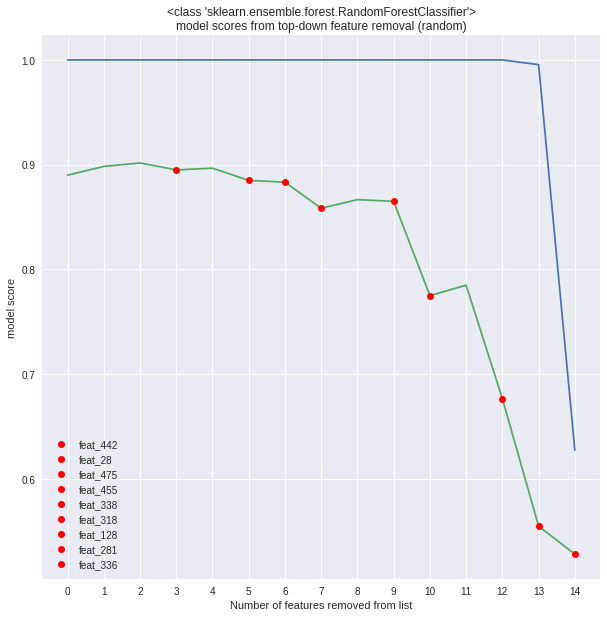

(    train_score  val_score
 0        1.0000   0.890000
 1        1.0000   0.898333
 2        1.0000   0.901667
 3        1.0000   0.895000
 4        1.0000   0.896667
 5        1.0000   0.885000
 6        1.0000   0.883333
 7        1.0000   0.858333
 8        1.0000   0.866667
 9        1.0000   0.865000
 10       1.0000   0.775000
 11       1.0000   0.785000
 12       1.0000   0.676667
 13       0.9955   0.555000
 14       0.6275   0.528333, [442, 28, 475, 455, 338, 318, 128, 281, 336])

In [69]:
ma_best.plot_top_down_feature_elimination_scores(best_score_list, \
                                               model=RandomForestClassifier, \
                                               params=rf_params, random=True)

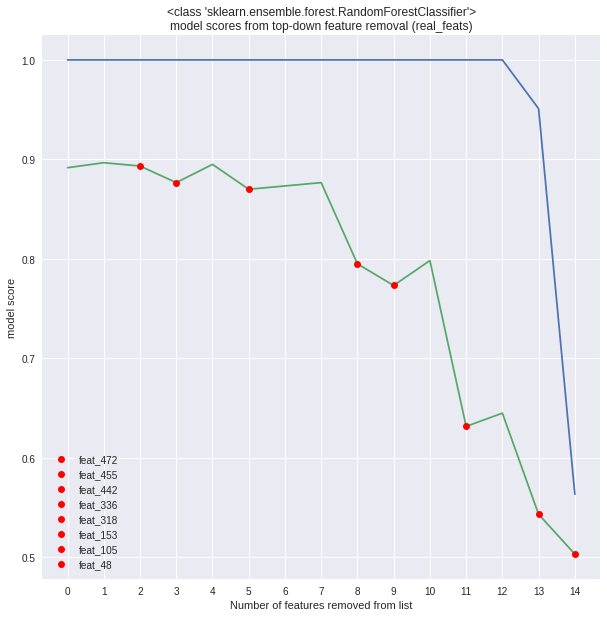

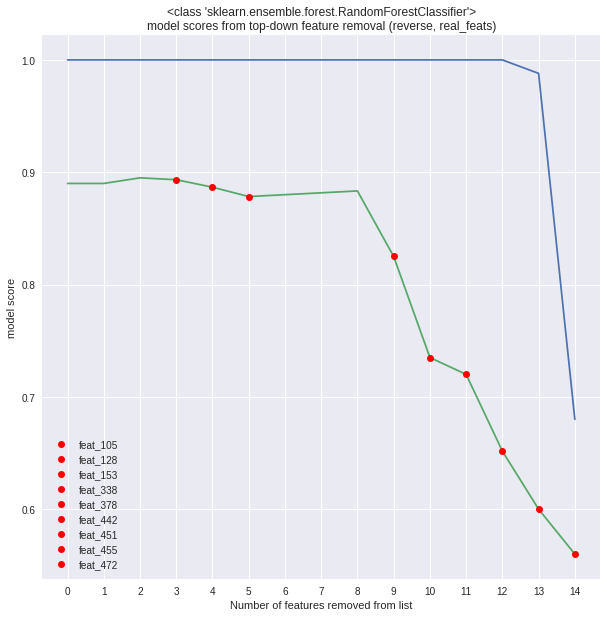

TOP REAL FEATURES: [105, 128, 153, 318, 336, 338, 378, 442, 455, 472]


[105, 128, 153, 318, 336, 338, 378, 442, 455, 472]

In [73]:
ma_best.list_top_dipped_feats(best_score_list, \
                               model=RandomForestClassifier, \
                               params=rf_params)

In [100]:
ma_yeahhh = madelon_analyzer(train_uci_df, val_uci_df)

In [86]:
ma_yeahhh.train_val_scorer_df_maker(ma_yeahhh_list, 'yeahhh',\
                                   model=RandomForestClassifier, \
                                   params=rf_params)

yeahhh
train_score  1.000000
val_score    0.898333

In [88]:
pwd

'/home/jovyan/Documents/ga-dsi/lessons-dsi/Week_4/DSI-SF-6-python-intro-object-oriented-code'

In [21]:
rf_params = {
    'n_estimators':[10,50,100,200],
    'max_features':['auto','log2'],
}

bf_df = ma_yeahhh.brute_force_feature_combination_score_generator(top_7_real_features, \
                                                                  RandomForestClassifier, rf_params, 3)



Number of combinations: 35


In [89]:
bf_df['features'][:10].values

array([[128, 338, 475], [338, 378, 475], [241, 338, 378], [128, 241, 338],
       [64, 128, 338], [64, 338, 378], [128, 336, 338], [128, 336, 475],
       [336, 338, 378], [64, 338, 475]], dtype=object)

In [102]:
ma_yeahhh.train_val_scorer_df_maker(ma_yeahhh.make_set_from_list_of_lists(bf_df['features'][:10].values), \
                                                                         'yeahhh', model=RandomForestClassifier, \
                                                                          params=rf_params) 

yeahhh
train_score  1.000000
val_score    0.786667